In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# Any results you write to the current directory are saved as output.

In [3]:
import numpy as np # linear algebra
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


# read datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# process columns, apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))
train.head()
#(Initial code borrowed from this notebook: https://www.kaggle.com/uluumy/mercedez-baseline-2)

Shape train: (4209, 378)
Shape test: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = train.drop('y', axis = 1)
Y_train = train['y']

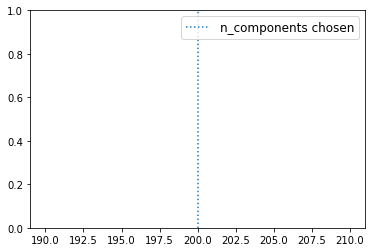

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

n_components = [50, 100, 200]

regr = RandomForestRegressor()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', regr)])

estimator = GridSearchCV(pipe,dict(pca__n_components=n_components))

estimator.fit(X_train, Y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [6]:
y_pred = estimator.predict(test)

In [7]:
ID = list(test['ID'])
y_pred = list(y_pred)
print (y_pred[:5], ID[:5])

[80.561999999999983, 92.486999999999995, 77.393999999999991, 78.486000000000004, 116.31100000000001] [1, 2, 3, 4, 5]


In [8]:
outputfile = open('result.csv', "w+")
outputfile.write("ID,y\n")
print (len(ID), len(y_pred))
for i in range(len(ID)):
    outputfile.write(str(ID[i])+ "," + str(y_pred[i])+"\n" )
outputfile.close()    
    

4209 4209
